In [47]:
import jcopdl
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!gdown https://drive.google.com/uc?id=1aPgQGEWnekL4MwhfoQIUUs8m2cT1Coon

In [ ]:
!pip install jcopdl

In [ ]:
!unzip /content/panorama.zip -d .

In [14]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & Dataloader

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [29]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.78, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [30]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur & Config

### Contoh cara pakai Pretrained-Model

In [31]:
from torchvision.models import mobilenet_v2

weights = torch.load('/content/mobilenet_v2-b0353104.pth', map_location="cuda")
mnet = mobilenet_v2(pretrained=False)

mnet.load_state_dict(weights)
mnet = mnet.to(device)

for param in mnet.parameters():
    param.requires_grad = False

In [32]:
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [33]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        weights = torch.load('/content/mobilenet_v2-b0353104.pth', map_location="cuda")
        mnet = mobilenet_v2(pretrained=False)
        mnet.load_state_dict(weights)
        self.mnet = mnet.to(device)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [34]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size" : bs,
    "crop_size"  : crop_size
    
})

## Phase 1: Adaptation (lr standard + patience kecil)

In [38]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [39]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))




Epoch     1
Train_cost  = 0.5236 | Test_cost  = 0.4000 | 




Epoch     2
Train_cost  = 0.3732 | Test_cost  = 0.3299 | 




Epoch     3
Train_cost  = 0.3073 | Test_cost  = 0.2867 | 




Epoch     4
Train_cost  = 0.2841 | Test_cost  = 0.2691 | 




Epoch     5
Train_cost  = 0.2583 | Test_cost  = 0.2561 | 




Epoch     6
Train_cost  = 0.2500 | Test_cost  = 0.2441 | 




Epoch     7
Train_cost  = 0.2404 | Test_cost  = 0.2388 | 




Epoch     8
Train_cost  = 0.2449 | Test_cost  = 0.2312 | 




Epoch     9
Train_cost  = 0.2277 | Test_cost  = 0.2304 | 




Epoch    10
Train_cost  = 0.2220 | Test_cost  = 0.2408 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2304




Epoch    11
Train_cost  = 0.2266 | Test_cost  = 0.2266 | 




Epoch    12
Train_cost  = 0.2153 | Test_cost  = 0.2249 | 




Epoch    13
Train_cost  = 0.2182 | Test_cost  = 0.2175 | 




Epoch    14
Train_cost  = 0.2108 | Test_cost  = 0.2184 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2175




Epoch    15
Train_cost  = 0.2064 | Test_cost  = 0.2119 | 




Epoch    16
Train_cost  = 0.2109 | Test_cost  = 0.2203 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2119




Epoch    17
Train_cost  = 0.1976 | Test_cost  = 0.2152 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2119
==> Execute Early Stopping at epoch: 17 | Best test_cost: 0.2119
==> Best model is saved at model


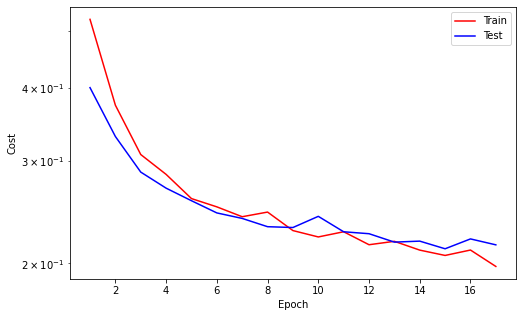

In [40]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Phase 2: Fine-tuning (lr dikecilin, patience ditambah)

In [41]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))




Epoch    18
Train_cost  = 0.1918 | Test_cost  = 0.2070 | 




Epoch    19
Train_cost  = 0.1760 | Test_cost  = 0.1979 | 




Epoch    20
Train_cost  = 0.1638 | Test_cost  = 0.1882 | 


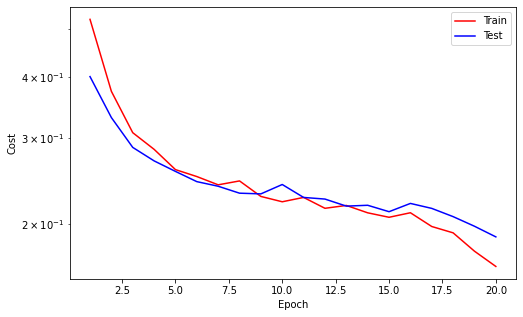



Epoch    21
Train_cost  = 0.1546 | Test_cost  = 0.1858 | 




Epoch    22
Train_cost  = 0.1507 | Test_cost  = 0.1826 | 




Epoch    23
Train_cost  = 0.1440 | Test_cost  = 0.1786 | 




Epoch    24
Train_cost  = 0.1363 | Test_cost  = 0.1771 | 




Epoch    25
Train_cost  = 0.1346 | Test_cost  = 0.1819 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1771




Epoch    26
Train_cost  = 0.1242 | Test_cost  = 0.1764 | 




Epoch    27
Train_cost  = 0.1260 | Test_cost  = 0.1751 | 




Epoch    28
Train_cost  = 0.1177 | Test_cost  = 0.1786 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1751




Epoch    29
Train_cost  = 0.1104 | Test_cost  = 0.1690 | 




Epoch    30
Train_cost  = 0.1126 | Test_cost  = 0.1782 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1690




Epoch    31
Train_cost  = 0.1088 | Test_cost  = 0.1715 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1690




Epoch    32
Train_cost  = 0.1022 | Test_cost  = 0.1711 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1690




Epoch    33
Train_cost  = 0.1004 | Test_cost  = 0.1654 | 




Epoch    34
Train_cost  = 0.0959 | Test_cost  = 0.1660 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1654




Epoch    35
Train_cost  = 0.0964 | Test_cost  = 0.1682 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1654




Epoch    36
Train_cost  = 0.0902 | Test_cost  = 0.1630 | 




Epoch    37
Train_cost  = 0.0877 | Test_cost  = 0.1596 | 




Epoch    38
Train_cost  = 0.0845 | Test_cost  = 0.1626 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1596




Epoch    39
Train_cost  = 0.0840 | Test_cost  = 0.1721 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1596




Epoch    40
Train_cost  = 0.0808 | Test_cost  = 0.1675 | 


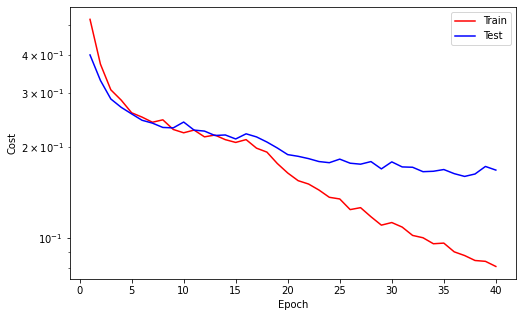

==> EarlyStop patience =  3 | Best test_cost: 0.1596




Epoch    41
Train_cost  = 0.0807 | Test_cost  = 0.1635 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1596




Epoch    42
Train_cost  = 0.0762 | Test_cost  = 0.1597 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1596
==> Execute Early Stopping at epoch: 42 | Best test_cost: 0.1596
==> Best model is saved at model


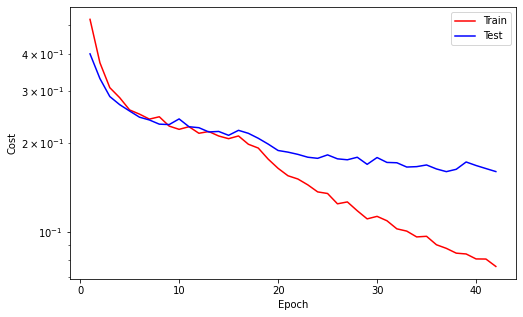

In [42]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Predict

In [43]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [51]:
attack_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
attackloader = DataLoader(attack_set, batch_size=1, shuffle=True)

tensor([[[0.4118, 0.4118, 0.4157,  ..., 0.6039, 0.6039, 0.6039],
         [0.4157, 0.4157, 0.4235,  ..., 0.6118, 0.6118, 0.6118],
         [0.4196, 0.4196, 0.4235,  ..., 0.6118, 0.6118, 0.6118],
         ...,
         [0.5765, 0.5765, 0.5765,  ..., 0.6510, 0.6627, 0.6314],
         [0.5569, 0.5608, 0.5608,  ..., 0.6275, 0.5725, 0.5569],
         [0.5569, 0.5569, 0.5529,  ..., 0.5843, 0.5569, 0.5961]],

        [[0.6745, 0.6745, 0.6784,  ..., 0.7608, 0.7608, 0.7608],
         [0.6784, 0.6784, 0.6784,  ..., 0.7608, 0.7608, 0.7608],
         [0.6824, 0.6784, 0.6784,  ..., 0.7608, 0.7608, 0.7608],
         ...,
         [0.4941, 0.4941, 0.4941,  ..., 0.6824, 0.6941, 0.6627],
         [0.4745, 0.4784, 0.4784,  ..., 0.6588, 0.6039, 0.5882],
         [0.4745, 0.4745, 0.4706,  ..., 0.6157, 0.5882, 0.6275]],

        [[0.8980, 0.8902, 0.8941,  ..., 0.9020, 0.9020, 0.9020],
         [0.8941, 0.8941, 0.8980,  ..., 0.9020, 0.9020, 0.9020],
         [0.8980, 0.8980, 0.8941,  ..., 0.9020, 0.9020, 0.

In [44]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)
preds

tensor([[0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1

# Sanity Check

In [45]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

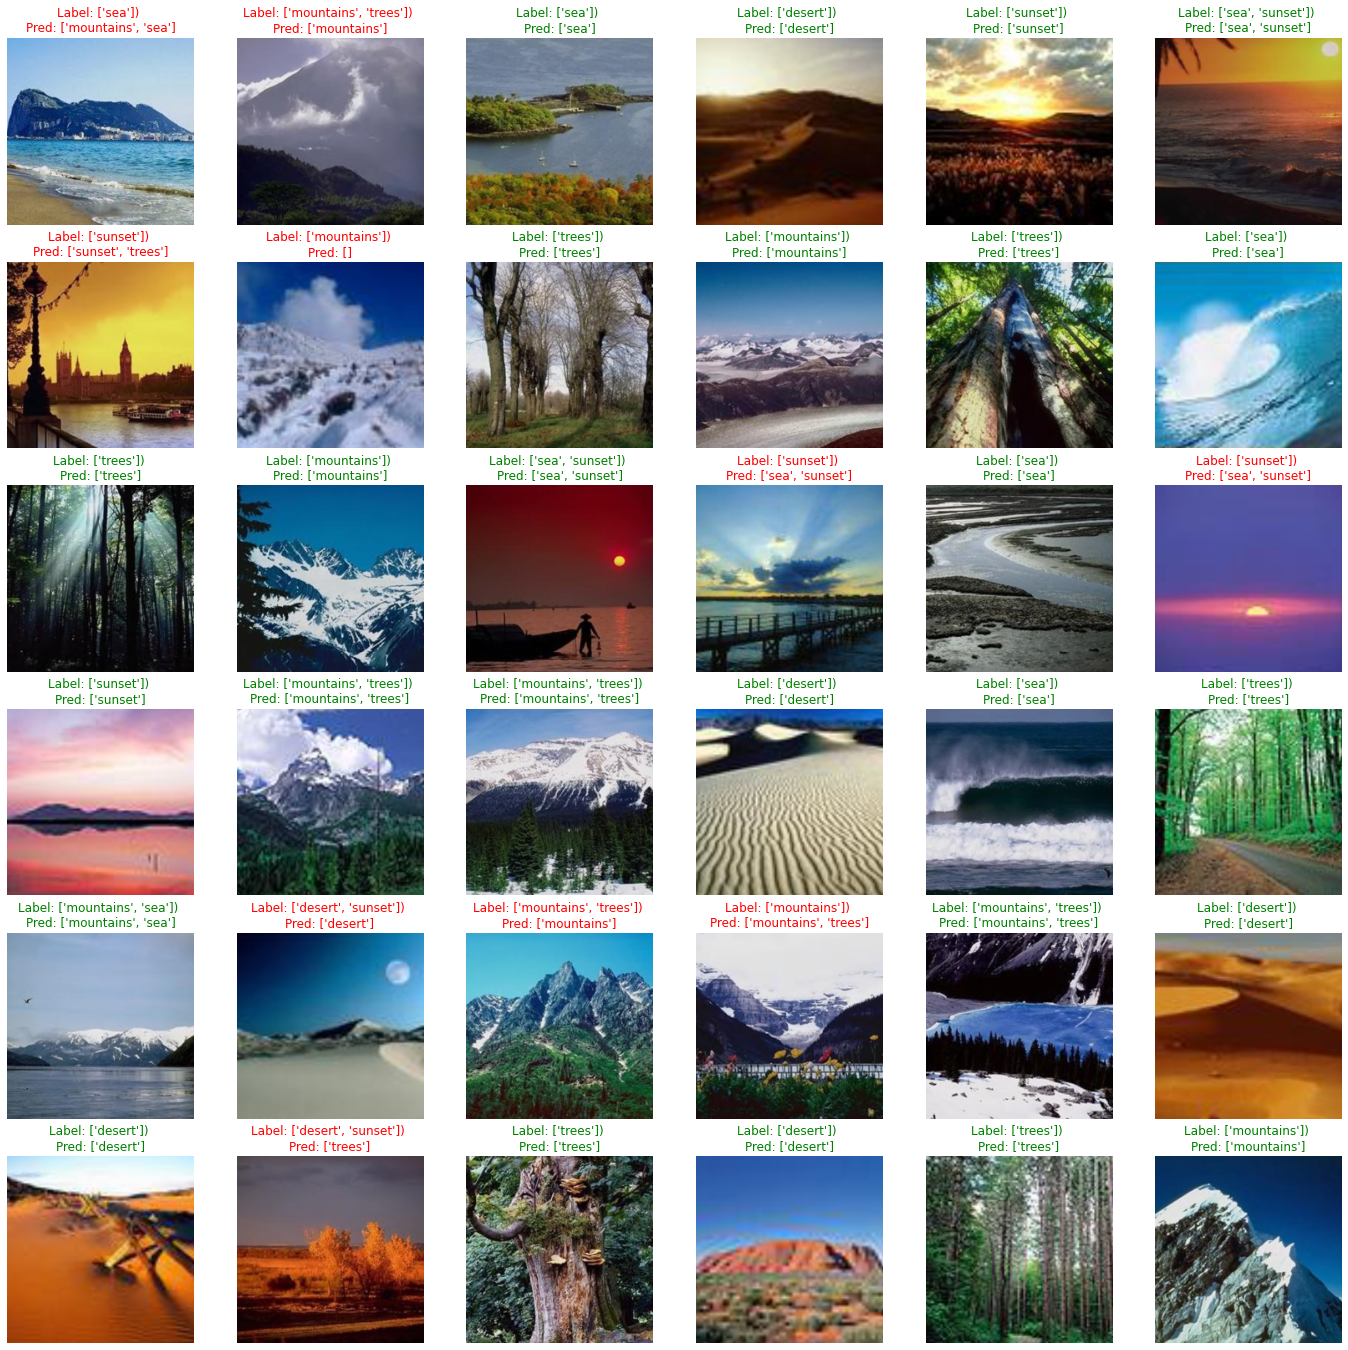

In [48]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
    font = {"color" : 'r'} if (pred != label).any() else {"color": 'g'}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"Label: {label}) \nPred: {pred}", fontdict=font);
    ax.axis('off');

In [52]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/configs.pth (deflated 51%)
  adding: content/model/weights_best.pth (deflated 8%)
  adding: content/model/logs.pth (deflated 25%)
